In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_9015/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

## Kappa Measurement

1. Play Constant Amp Measurement
2. Wait Variable Duration tau_k
3. Photon Measurement

In [9]:
freq_low = -30.0 * MHz
freq_high = 2.0 * MHz
num_freqs = 49
ac_freq_linspace = np.linspace(freq_low, freq_high, num_freqs)

kappa_delay_low = 15 * ns
kappa_delay_high = 150 * ns
num_kappa_exps = 11
kappa_delay_linspace = np.linspace(kappa_delay_low, kappa_delay_high, num_kappa_exps)

588


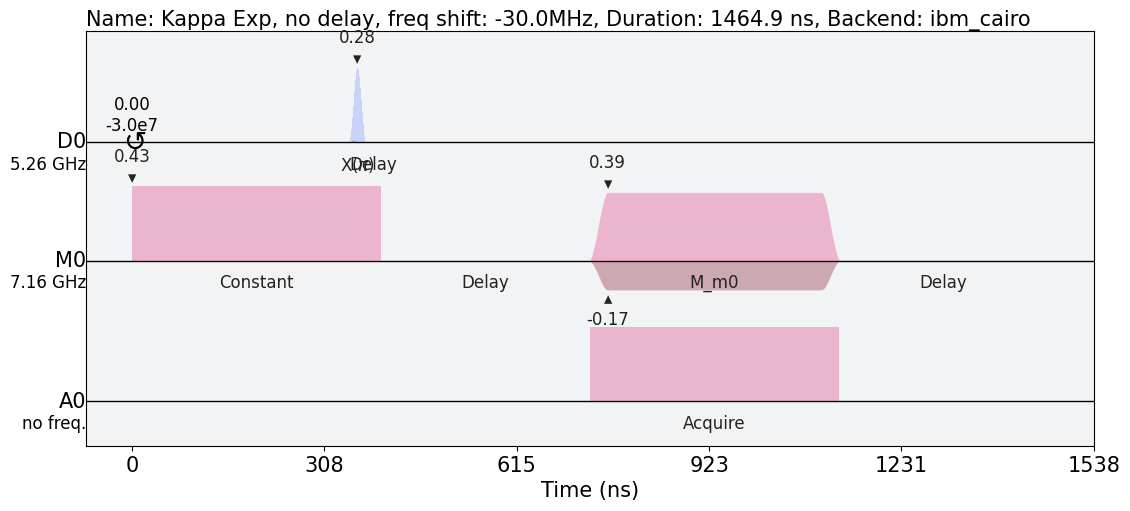

In [13]:
from helper_funcs.utils import *

kappa_exp = []

for freq_shift in ac_freq_linspace:
    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name=f'Kappa Exp, no delay, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
    ) as kappa_no_delay_sched:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)

        pulse.shift_frequency(freq_shift, qubit_chan)

        with pulse.align_right():
            pulse.play(
                pulse.Constant(duration=measure_pulse.duration, amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(x_pulse.duration, qubit_chan)
        pulse.delay(measure_delay.duration, meas_chan)
        pulse.measure(qubit, pulse.MemorySlot(qubit))
    kappa_exp.append(kappa_no_delay_sched)

for kappa_delay_sec in kappa_delay_linspace:
    kappa_delay_dt = get_closest_multiple_of_16(get_dt_from(kappa_delay_sec))
    kappa_delay_sec = kappa_delay_dt * dt

    for freq_shift in ac_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'Kappa Exp, delay: {int(1e3*kappa_delay_sec/ns)/1e3}ns, freq shift: {int(1e3*freq_shift/MHz)/1e3}MHz'
        ) as kappa_delay_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)

            pulse.play(
                pulse.Constant(duration=measure_pulse.duration, amp=measure_pulse.amp),
                meas_chan
            )
            pulse.delay(kappa_delay_dt, meas_chan)
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(measure_delay.duration, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        kappa_exp.append(kappa_delay_sched)

print(len(kappa_exp))

kappa_exp[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

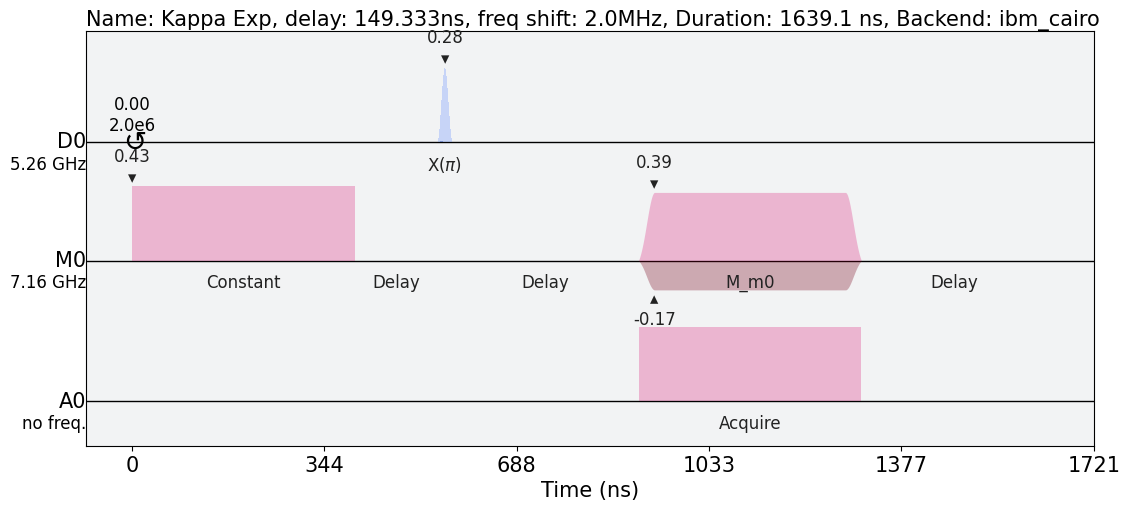

In [15]:
acquisition_checker(kappa_exp)
exp_1, exp_2 = np.array(kappa_exp).reshape(2, -1).tolist()

exp_2[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [17]:
num_shots = 4096
rep_delay = 499.0 * 1e-6

job_experiment = backend.run(exp_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

/Users/chatt07/Desktop/readout_env/lib/python3.9/site-packages/qiskit/compiler/assembler.py:443: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn(


Job Status: job is actively running

KeyboardInterrupt: 

In [18]:
job_1 = provider.backend.retrieve_job('cpa52n2ja3gg0080njd0')
job_2 = provider.backend.retrieve_job('cpa52s3btqp0008fj4e0')

In [19]:
result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)

In [20]:
mean_1 = np.angle(np.mean(result_1, axis=-1))
mean_2 = np.angle(np.mean(result_2, axis=-1))

kappa_res = np.concatenate((mean_1, mean_2)).reshape(num_kappa_exps + 1, -1)

In [25]:
kappa_fit_res = np.zeros_like(kappa_res)
kappa_freqs = np.zeros(len(kappa_fit_res))

for ind, res_obj in enumerate(kappa_res):
    init_params = [1., -15., 15., -1.]
    params, res = fit_gaussian_with_offset(ac_freq_linspace/MHz, res_obj, init_params)
    kappa_fit_res[ind] = res
    kappa_freqs[ind] = params[1]

[1.81038830e+01 1.98243747e+01 4.38093518e-03]


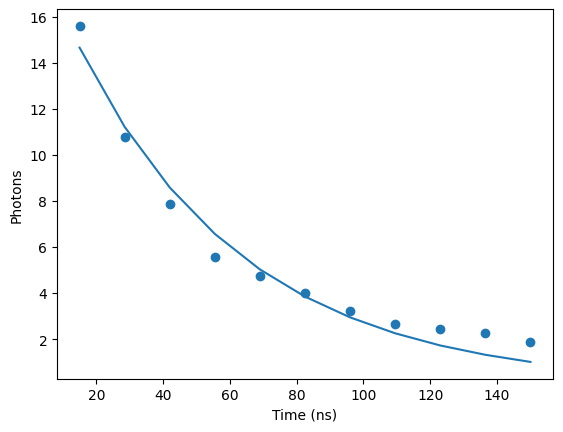

In [35]:
composite_linspace = np.concatenate((np.array([0.]), kappa_delay_linspace))
chi = -0.65

def exp_func(x, A, k, b):
    return A * np.exp(-k * (x - b))

ts = kappa_delay_linspace
y_vals = kappa_freqs[1:]/chi

init_params = [20, 25, 0.01]
params, cov = fit_function(ts/us, y_vals, exp_func, init_params)

print(params)

plt.scatter(ts/ns, y_vals, label='data')
plt.plot(ts/ns, exp_func(ts/us, *params), label='fit')
plt.xlabel('Time (ns)')
plt.ylabel('Photons')
plt.show()